In [1]:
! pip install SimpleITK

In [1]:
import numpy as np
import SimpleITK as sitk

#DATA


###GET DATA

In [2]:
from glob import glob
from typing import  List

In [3]:
BUY_file_paths: List[str] =  sorted(glob("./BUY/*.nii.gz"))  #68 files
#EAT_file_paths: List[str] =  sorted(glob("/content/drive/MyDrive/Integradora/Data/EAT/*.nii.gz"))  #files
GAMBLE_file_paths: List[str] =  sorted(glob("./GAMBLE/*.nii.gz"))  #7 files
SEX_file_paths: List[str] =  sorted(glob("./SEX/*.nii.gz"))  #42 files

PD_file_paths: List[str] =  sorted(glob("./PD/*.nii.gz"))  #100 files

In [4]:
print(len(BUY_file_paths), BUY_file_paths[:3])
#print(len(EAT_file_paths), EAT_file_paths[:3])
print(len(GAMBLE_file_paths), GAMBLE_file_paths[:3])
print(len(SEX_file_paths), SEX_file_paths[:3])

print(len(PD_file_paths), PD_file_paths[:3])

68 ['./BUY\\3536.nii.gz', './BUY\\3565.nii.gz', './BUY\\3863.nii.gz']
7 ['./GAMBLE\\3536.nii.gz', './GAMBLE\\3565.nii.gz', './GAMBLE\\3863.nii.gz']
42 ['./SEX\\3062.nii.gz', './SEX\\3068.nii.gz', './SEX\\3073.nii.gz']
100 ['./PD\\S101968.nii.gz', './PD\\S101973.nii.gz', './PD\\S103294.nii.gz']


##SPLIT DATA

In [5]:
X_dataset = []
y_dataset = []

X_dataset.extend(PD_file_paths), y_dataset.extend([1] * len(PD_file_paths))
X_dataset.extend(BUY_file_paths), y_dataset.extend([2] * len(BUY_file_paths))
#X_dataset.extend(EAT_file_paths), y_dataset.extend([3] * len(EAT_file_paths))
X_dataset.extend(GAMBLE_file_paths), y_dataset.extend([4] * len(GAMBLE_file_paths))
X_dataset.extend(SEX_file_paths), y_dataset.extend([5] * len(SEX_file_paths))

(None, None)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.2, stratify=y_dataset)

In [7]:
print("Dataset:", len(X_dataset), len(y_dataset))
print("Train:", len(X_train), len(y_train))
print("Test:", len(X_test), len(y_test))

Dataset: 217 217
Train: 173 173
Test: 44 44


##PREPROSSESING

In [8]:
def get_category(category, is_binary = True):
  result = np.zeros(2 if is_binary else 5)
  if is_binary:
    return 1 if category == 1 else 0
  elif category == 1:
    result[0] = 1
  else:
    result[category-1] = 1
  return result

In [9]:
def get_categories(y_data):
  categories = None
  is_first = True
  for category in y_data:
    if is_first:
      categories = np.array([get_category(category)])
      is_first = False
    else:
      categories = np.concatenate((categories,[get_category(category)]))
  return categories

In [10]:
print(get_category(5, True), get_category(5, False))
print(get_category(1, True), get_category(1, False))

0 [0. 0. 0. 0. 1.]
1 [1. 0. 0. 0. 0.]


## 3D

In [46]:
import cv2

def get_slices_3d(path, category):
    img = sitk.ReadImage(path, sitk.sitkFloat64)
    arr = sitk.GetArrayFromImage(img)

    #normalize the matrix, numbers between 0.0 - 1.0
    arr = arr / arr.max()
    
    slices = np.array([arr])
    slices = slices.reshape(1, -1, slices.shape[1], slices.shape[2], 1)
    slices_cat = np.array([get_category(category)])
    
    return slices, slices_cat

In [47]:
def get_slices_per_group_3d(paths, categories):
    group = None
    group_cat = None

    count = 1
    for i in range(len(paths)):
        path = paths[i]
        if i == 0:
            group, group_cat = get_slices_3d(path, categories[i])
        else:
            new_group, new_group_cat = get_slices_3d(path, categories[i])
            group = np.concatenate((group, new_group))
            group_cat = np.concatenate((group_cat, new_group_cat))

        print("-> [%d/%d] Image processed." %(count,len(paths)))
        count+=1
    return group, group_cat

In [48]:
#test with one image
slices, slices_cat = get_slices_3d(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(1, 181, 181, 217, 1)
(1,)


In [49]:
slices, slices_cat = get_slices_per_group_3d(X_dataset[:3], y_dataset[:3])
print(slices.shape)
print(slices_cat.shape)

-> [1/3] Image processed.
-> [2/3] Image processed.
-> [3/3] Image processed.
(3, 181, 181, 217, 1)
(3,)


## AXIAL
arr[ xxx , : , : ] axial

In [18]:
import cv2

def get_slices_axial(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[i, : , : ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [19]:
def get_slices_per_group_axial(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_axial(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_axial(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [20]:
#test with one image
slices, slices_cat = get_slices_axial(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(30, 224, 224)
(30,)


## CORONAL
arr[ : , xxx , : ] coronal 

In [21]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_coronal(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, i , : ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [22]:
def get_slices_per_group_coronal(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_coronal(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_coronal(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [23]:
#test with one image
slices, slices_cat = get_slices_coronal(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(67, 224, 224)
(67,)


## SAGITAL
arr[ : , : , xxx ] sagital 

In [24]:
import cv2
# type: the number of the group
# group_n: the count of diferent groups
# for example,we can have the groups 
#    1) [EAT, GAMBLE, SEX, BUY, PURE] and the image is from GAMBLE
#     -> type = 2
#     -> group_n = 5
#    2) or [PURE, ICD] and the image is from PURE
#     -> type = 1
#     -> group_n = 2
#output:
#     -> normalized array of the slices 
#     -> the category of each image in one-hot encoded.
# for example
#   1) [0,1,0,0,0], and 
#   2) [1,0]
def get_slices_sagital(path, category):
  img = sitk.ReadImage(path, sitk.sitkFloat64)
  arr = sitk.GetArrayFromImage(img)

  #normalize the matrix, numbers between 0.0 - 1.0
  arr = arr / arr.max()

  slices = None
  slices_cat = None
  count = 0

  for i in range(arr.shape[0]):
    slice = arr[:, : , i ]
    slice = cv2.resize(slice, (224, 224), interpolation=cv2.INTER_CUBIC)
    slice[slice < 0] = 0
    if slice.max() != 0:
      if count == 0:
        slices = np.array([slice])
        slices_cat = np.array([get_category(category)])
      else:
        slices = np.concatenate((slices,[slice]))
        slices_cat = np.concatenate((slices_cat,[get_category(category)]))
      count+=1
  #print("->", count , "slices of", arr.shape[0], "where used for image", path)
  return slices, slices_cat

In [25]:
def get_slices_per_group_sagital(paths, categories):
  group = None
  group_cat = None

  count = 1
  for i in range(len(paths)):
    path = paths[i]
    if i == 0:
      group, group_cat = get_slices_sagital(path, categories[i])
    else:
      new_group, new_group_cat = get_slices_sagital(path, categories[i])
      group = np.concatenate((group, new_group))
      group_cat = np.concatenate((group_cat, new_group_cat))

    print("-> [%d/%d] Slices processed %d." %(count,len(paths), group.shape[0] ))
    count+=1
  return group, group_cat

In [26]:
#test with one image
slices, slices_cat = get_slices_sagital(X_dataset[0], y_dataset[0])
print(slices.shape)
print(slices_cat.shape)

(120, 224, 224)
(120,)


# MODEL (BINARY)

## 3D

In [59]:
X_3d_train, y_3d_train = get_slices_per_group_3d(X_train[:20], y_train[:20])
X_3d_test, y_3d_test = get_slices_per_group_3d(X_test[:5], y_test[:5])


-> [1/20] Image processed.
-> [2/20] Image processed.
-> [3/20] Image processed.
-> [4/20] Image processed.
-> [5/20] Image processed.
-> [6/20] Image processed.
-> [7/20] Image processed.
-> [8/20] Image processed.
-> [9/20] Image processed.
-> [10/20] Image processed.
-> [11/20] Image processed.
-> [12/20] Image processed.
-> [13/20] Image processed.
-> [14/20] Image processed.
-> [15/20] Image processed.
-> [16/20] Image processed.
-> [17/20] Image processed.
-> [18/20] Image processed.
-> [19/20] Image processed.
-> [20/20] Image processed.
-> [1/5] Image processed.
-> [2/5] Image processed.
-> [3/5] Image processed.
-> [4/5] Image processed.
-> [5/5] Image processed.


In [60]:
print("Train:",X_3d_train.shape, len(y_3d_train))
print("Test:",X_3d_test.shape, len(y_3d_test))

Train: (20, 181, 181, 217, 1) 20
Test: (5, 181, 181, 217, 1) 5


### VGG19 

In [61]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imageio
import tensorflow as tf

In [65]:
model = Sequential()
model.add(Conv3D(input_shape=(181,181,217,1),filters=20,kernel_size=3,padding="same", activation="relu"))
model.add(Conv3D(filters=64,kernel_size=3,padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=256, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Conv3D(filters=512, kernel_size=3, padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool3D(pool_size=2,strides=(2,2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 181, 181, 217, 20) 560       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 181, 181, 217, 64) 34624     
_________________________________________________________________
dropout_5 (Dropout)          (None, 181, 181, 217, 64) 0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 90, 90, 108, 64)   0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 90, 90, 108, 128)  221312    
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 90, 90, 108, 128)  442496    
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 90, 108, 128) 

In [66]:
checkpoint = ModelCheckpoint("vgg19_3d.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [67]:
hist = model.fit(X_3d_train, y_3d_train, batch_size=10,epochs=30,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/30


ResourceExhaustedError: in user code:

    c:\python39\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\python39\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\python39\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\python39\lib\site-packages\keras\engine\training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:628 apply_gradients
        self._create_all_weights(var_list)
    c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    c:\python39\lib\site-packages\keras\optimizer_v2\adam.py:119 _create_slots
        self.add_slot(var, 'v')
    c:\python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:901 add_slot
        weight = tf.Variable(
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:268 __call__
        return cls._variable_v2_call(*args, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:250 _variable_v2_call
        return previous_getter(
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3547 creator
        return next_creator(**kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3547 creator
        return next_creator(**kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3547 creator
        return next_creator(**kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\eager\def_function.py:746 variable_capturing_scope
        v = UnliftedInitializerVariable(
    c:\python39\lib\site-packages\tensorflow\python\ops\variables.py:270 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\eager\def_function.py:294 __init__
        initial_value = initial_value()
    c:\python39\lib\site-packages\keras\initializers\initializers_v2.py:145 __call__
        return tf.zeros(shape, dtype)
    c:\python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\array_ops.py:2915 wrapped
        tensor = fun(*args, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\array_ops.py:2976 zeros
        output = fill(shape, constant(zero, dtype=dtype), name=name)
    c:\python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\python39\lib\site-packages\tensorflow\python\ops\array_ops.py:240 fill
        result = gen_array_ops.fill(dims, value, name=name)
    c:\python39\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:3367 fill
        _ops.raise_from_not_ok_status(e, name)
    c:\python39\lib\site-packages\tensorflow\python\framework\ops.py:6941 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[76800,4096] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Fill]


In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
test_results = model.evaluate(X_3d_test, y_3d_test)
test_results

## AXIAL

In [15]:
X_axial_train, y_axial_train = get_slices_per_group_axial(X_train, y_train)
X_axial_train = X_axial_train.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

X_axial_test, y_axial_test = get_slices_per_group_axial(X_test, y_test)
X_axial_test = X_axial_test.reshape(-1, X_axial_train.shape[1], X_axial_train.shape[2], 1)

-> [1/173] Slices processed 30.
-> [2/173] Slices processed 58.
-> [3/173] Slices processed 88.
-> [4/173] Slices processed 118.
-> [5/173] Slices processed 146.
-> [6/173] Slices processed 173.
-> [7/173] Slices processed 200.
-> [8/173] Slices processed 224.
-> [9/173] Slices processed 251.
-> [10/173] Slices processed 278.
-> [11/173] Slices processed 308.
-> [12/173] Slices processed 335.
-> [13/173] Slices processed 362.
-> [14/173] Slices processed 387.
-> [15/173] Slices processed 417.
-> [16/173] Slices processed 446.
-> [17/173] Slices processed 475.
-> [18/173] Slices processed 502.
-> [19/173] Slices processed 532.
-> [20/173] Slices processed 551.
-> [21/173] Slices processed 579.
-> [22/173] Slices processed 604.
-> [23/173] Slices processed 605.
-> [24/173] Slices processed 632.
-> [25/173] Slices processed 657.
-> [26/173] Slices processed 686.
-> [27/173] Slices processed 716.
-> [28/173] Slices processed 746.
-> [29/173] Slices processed 770.
-> [30/173] Slices process

C:\Users\josie\AppData\Local\Temp/ipykernel_3568/1751870067.py:22: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [86/173] Slices processed 2533.
-> [87/173] Slices processed 2560.
-> [88/173] Slices processed 2584.
-> [89/173] Slices processed 2612.
-> [90/173] Slices processed 2642.
-> [91/173] Slices processed 2669.
-> [92/173] Slices processed 2699.
-> [93/173] Slices processed 2729.
-> [94/173] Slices processed 2759.
-> [95/173] Slices processed 2789.
-> [96/173] Slices processed 2817.
-> [97/173] Slices processed 2847.
-> [98/173] Slices processed 2865.
-> [99/173] Slices processed 2890.
-> [100/173] Slices processed 2916.
-> [101/173] Slices processed 2945.
-> [102/173] Slices processed 2972.
-> [103/173] Slices processed 3001.
-> [104/173] Slices processed 3029.
-> [105/173] Slices processed 3059.
-> [106/173] Slices processed 3085.
-> [107/173] Slices processed 3111.
-> [108/173] Slices processed 3141.
-> [109/173] Slices processed 3171.
-> [110/173] Slices processed 3198.
-> [111/173] Slices processed 3225.
-> [112/173] Slices processed 3255.
-> [113/173] Slices processed 3285.
-> [11

In [16]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_axial_train.shape[0],X_axial_train.shape[1],X_axial_train.shape[2],X_axial_train.shape[3], len(y_axial_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_axial_test.shape[0],X_axial_test.shape[1],X_axial_test.shape[2],X_axial_test.shape[3], len(y_axial_test)))

Train: X:(5004, 224, 224, 1), y: 5004
Test: X:(1242, 224, 224, 1), y: 1242


###VGG19

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imageio
import tensorflow as tf

In [18]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 128)     0

In [19]:
checkpoint = ModelCheckpoint("vgg19_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [21]:
hist = model.fit(X_axial_train, y_axial_train, batch_size=10,epochs=30,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/30
401/401 [==============================] - 3665s 9s/step - loss: nan - accuracy: 0.5528 - val_loss: nan - val_accuracy: 0.5165

Epoch 00001: val_accuracy improved from -inf to 0.51648, saving model to vgg19_1.h5
Epoch 2/30
401/401 [==============================] - 3659s 9s/step - loss: nan - accuracy: 0.5528 - val_loss: nan - val_accuracy: 0.5165

Epoch 00002: val_accuracy did not improve from 0.51648
Epoch 3/30
401/401 [==============================] - 3693s 9s/step - loss: nan - accuracy: 0.5528 - val_loss: nan - val_accuracy: 0.5165

Epoch 00003: val_accuracy did not improve from 0.51648
Epoch 4/30
401/401 [==============================] - 3717s 9s/step - loss: nan - accuracy: 0.5528 - val_loss: nan - val_accuracy: 0.5165

Epoch 00004: val_accuracy did not improve from 0.51648
Epoch 5/30
401/401 [==============================] - 3753s 9s/step - loss: nan - accuracy: 0.5528 - val_loss: nan - val_accuracy: 0.5165

Epoch 00005: val_accuracy did not improve from 0.51648
E

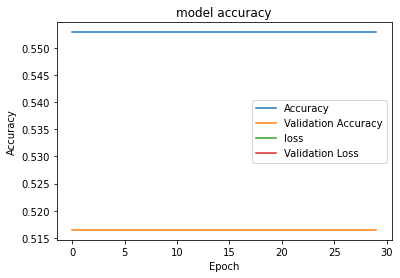

In [23]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [25]:
test_results = model.evaluate(X_axial_test, y_axial_test)
test_results

39/39 [==============================] - 210s 5s/step - loss: nan - accuracy: 0.5370


[nan, 0.5370370149612427]

# CORONAL

In [17]:
X_coronal_train, y_coronal_train = get_slices_per_group_coronal(X_train, y_train)
X_coronal_train = X_coronal_train.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/173] Slices processed 67.
-> [2/173] Slices processed 134.
-> [3/173] Slices processed 201.
-> [4/173] Slices processed 268.
-> [5/173] Slices processed 335.
-> [6/173] Slices processed 402.
-> [7/173] Slices processed 469.
-> [8/173] Slices processed 536.
-> [9/173] Slices processed 603.
-> [10/173] Slices processed 670.
-> [11/173] Slices processed 737.
-> [12/173] Slices processed 804.
-> [13/173] Slices processed 871.


C:\Users\josie\AppData\Local\Temp/ipykernel_5444/1790016269.py:22: RuntimeWarning: invalid value encountered in true_divide
  arr = arr / arr.max()


-> [14/173] Slices processed 1052.
-> [15/173] Slices processed 1119.
-> [16/173] Slices processed 1186.
-> [17/173] Slices processed 1253.
-> [18/173] Slices processed 1320.
-> [19/173] Slices processed 1387.
-> [20/173] Slices processed 1454.
-> [21/173] Slices processed 1521.
-> [22/173] Slices processed 1588.
-> [23/173] Slices processed 1655.
-> [24/173] Slices processed 1722.
-> [25/173] Slices processed 1789.
-> [26/173] Slices processed 1856.
-> [27/173] Slices processed 1923.
-> [28/173] Slices processed 1990.
-> [29/173] Slices processed 2057.
-> [30/173] Slices processed 2124.
-> [31/173] Slices processed 2191.
-> [32/173] Slices processed 2258.
-> [33/173] Slices processed 2325.
-> [34/173] Slices processed 2392.
-> [35/173] Slices processed 2459.
-> [36/173] Slices processed 2526.
-> [37/173] Slices processed 2593.
-> [38/173] Slices processed 2660.
-> [39/173] Slices processed 2727.
-> [40/173] Slices processed 2794.
-> [41/173] Slices processed 2861.
-> [42/173] Slices p

In [18]:
X_coronal_test, y_coronal_test = get_slices_per_group_coronal(X_test, y_test)
X_coronal_test = X_coronal_test.reshape(-1, X_coronal_train.shape[1], X_coronal_train.shape[2], 1)

-> [1/44] Slices processed 67.
-> [2/44] Slices processed 134.
-> [3/44] Slices processed 201.
-> [4/44] Slices processed 268.
-> [5/44] Slices processed 335.
-> [6/44] Slices processed 402.
-> [7/44] Slices processed 469.
-> [8/44] Slices processed 536.
-> [9/44] Slices processed 603.
-> [10/44] Slices processed 670.
-> [11/44] Slices processed 737.
-> [12/44] Slices processed 804.
-> [13/44] Slices processed 871.
-> [14/44] Slices processed 938.
-> [15/44] Slices processed 1005.
-> [16/44] Slices processed 1072.
-> [17/44] Slices processed 1139.
-> [18/44] Slices processed 1206.
-> [19/44] Slices processed 1273.
-> [20/44] Slices processed 1340.
-> [21/44] Slices processed 1407.
-> [22/44] Slices processed 1474.
-> [23/44] Slices processed 1541.
-> [24/44] Slices processed 1608.
-> [25/44] Slices processed 1675.
-> [26/44] Slices processed 1742.
-> [27/44] Slices processed 1809.
-> [28/44] Slices processed 1876.
-> [29/44] Slices processed 1943.
-> [30/44] Slices processed 2010.
-> [

In [19]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_coronal_train.shape[0],X_coronal_train.shape[1],X_coronal_train.shape[2],X_coronal_train.shape[3], len(y_coronal_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_coronal_test.shape[0],X_coronal_test.shape[1],X_coronal_test.shape[2],X_coronal_test.shape[3], len(y_coronal_test)))

Train: X:(11597, 224, 224, 1), y: 11597
Test: X:(2904, 224, 224, 1), y: 2904


# VGG19

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import imageio
import tensorflow as tf

In [21]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.6))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.8))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Dropout(0.4))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

#Dense layer
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1000,activation="relu"))
model.add(Dense(1, activation="softmax"))

model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 128)     0

In [22]:
checkpoint = ModelCheckpoint("vgg19_coronal.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
#fit_generator(steps_per_epoch=1,generator=traindata, validation_data= testdata, validation_steps=1,epochs=50,callbacks=[checkpoint])
# hist = model.fit(traindata, testdata, batch_size=10, epochs=20, verbose=0, shuffle=True,validation_split=0.2,callbacks=[checkpoint])

In [ ]:
hist = model.fit(X_coronal_train, y_coronal_train, batch_size=10,epochs=50,validation_split=0.2, callbacks=[checkpoint])

Epoch 1/50
928/928 [==============================] - 8392s 9s/step - loss: nan - accuracy: 0.5174 - val_loss: nan - val_accuracy: 0.6246

Epoch 00001: val_accuracy improved from -inf to 0.62457, saving model to vgg19_coronal.h5
Epoch 2/50
928/928 [==============================] - 8386s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00002: val_accuracy did not improve from 0.62457
Epoch 3/50
928/928 [==============================] - 8388s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00003: val_accuracy did not improve from 0.62457
Epoch 4/50
928/928 [==============================] - 8408s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00004: val_accuracy did not improve from 0.62457
Epoch 5/50
928/928 [==============================] - 8387s 9s/step - loss: nan - accuracy: 0.5164 - val_loss: nan - val_accuracy: 0.6246

Epoch 00005: val_accuracy did not improve from 0.6

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# Sagital

In [ ]:
X_sagital_train, y_sagital_train = get_slices_per_group_sagital(X_train, y_train)
X_sagital_train = X_sagital_train.reshape(-1, X_sagital_train.shape[1], X_sagital_train.shape[2], 1)

-> [1/173] Slices processed 112.
-> [2/173] Slices processed 228.
-> [3/173] Slices processed 338.
-> [4/173] Slices processed 452.
-> [5/173] Slices processed 565.
-> [6/173] Slices processed 679.
-> [7/173] Slices processed 789.
-> [8/173] Slices processed 900.
-> [9/173] Slices processed 1011.
-> [10/173] Slices processed 1126.
-> [11/173] Slices processed 1249.
-> [12/173] Slices processed 1364.
-> [13/173] Slices processed 1476.
-> [14/173] Slices processed 1590.
-> [15/173] Slices processed 1710.
-> [16/173] Slices processed 1821.
-> [17/173] Slices processed 1934.
-> [18/173] Slices processed 2049.
-> [19/173] Slices processed 2155.
-> [20/173] Slices processed 2266.
-> [21/173] Slices processed 2379.
-> [22/173] Slices processed 2493.
-> [23/173] Slices processed 2609.
-> [24/173] Slices processed 2724.
-> [25/173] Slices processed 2843.
-> [26/173] Slices processed 2957.
-> [27/173] Slices processed 3072.
-> [28/173] Slices processed 3187.
-> [29/173] Slices processed 3298.
->

In [ ]:
print("Train: X:(%d, %d, %d, %d), y: %d" %(X_sagital_train.shape[0],X_sagital_train.shape[1],X_sagital_train.shape[2],X_sagital_train.shape[3], len(y_sagital_train)))
print("Test: X:(%d, %d, %d, %d), y: %d" %(X_sagital_test.shape[0],X_sagital_test.shape[1],X_sagital_test.shape[2],X_sagital_test.shape[3], len(y_sagital_test)))

#EXTRA

In [24]:
import cv2
img = sitk.ReadImage(PD_file_paths[1], sitk.sitkFloat64)
arr = sitk.GetArrayFromImage(img)
print(arr.shape, arr.min())

arr_reshaped = cv2.resize(arr[:, : , 100], (224, 224), interpolation=cv2.INTER_CUBIC)
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

(181, 217, 181) 0.0
(224, 224) 0.0


In [25]:
arr_reshaped[arr_reshaped < 0] = 0
print(arr_reshaped.shape, arr_reshaped.min())

(224, 224) 0.0


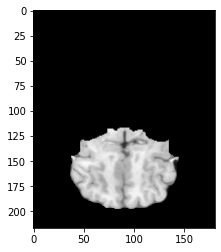

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(arr[60, : , :], cmap="gray")
plt.show()

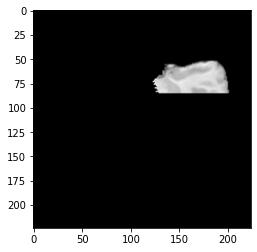

In [15]:
fig, ax = plt.subplots(num="MRI_demo")
ax.imshow(arr_reshaped, cmap="gray") 

plt.show()